In [1]:
from brian2 import *
import pandas as pd
import sympy
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import dh_parameters as dp

from scipy import optimize as op
%matplotlib notebook

from importlib import reload
reload(dp);

In [2]:
def generate_periodic_spike_times(rate, start_time, stop_time):
    ###unitless but do it in seconds to make it easy
    duration = stop_time - start_time
    num_spikes = np.floor(duration * rate)
    true_duration = num_spikes / rate
    spike_times = np.linspace(start_time, start_time + true_duration, num_spikes)
    return spike_times

def connect_neuron_groups(pre_group, post_group,
                          conductance_name = 'e',
                          p = 1, 
                          w_mu = 1 * nS, 
                          w_sigma = 0.1 * nS):
    on_pre_equation = 'g_' + conductance_name + '_post += w'
    S = Synapses(pre_group, post_group,model = 'w : siemens',
                             on_pre = on_pre_equation)
    S.connect(p = p)
    S.w =  w_mu + w_sigma * randn(S.w.shape[0])
    S.w['w < 0 * nS'] = 0 * nS
    return S

class neuron_group_constructor():
        
    def __init__(self):
        self.params = {}
    
    def select_cell_type(self, cell_type):
        self.params = dp.get_neuron_params(cell_type)
        return self
    
    def return_ta(self):
        N = self.params['N']
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.params['intrinsics']['I_ex_mu']
        I_ex_sigma = self.params['intrinsics']['I_ex_sigma']
        I_ex = (I_ex_mu + I_ex_sigma * randn(N))
        I_ex_array = np.tile(I_ex, (tb.shape[0],1))
        self.I_ex = TimedArray(I_ex_array,sim_dt)
        return I_ex_array
    
    def initialize_external_current_array(self):
        N = self.params['N']
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.params['intrinsics']['I_ex_mu']
        I_ex_sigma = self.params['intrinsics']['I_ex_sigma']
        I_ex = (I_ex_mu + I_ex_sigma * randn(N))
        self.I_ex = np.tile(I_ex, (tb.shape[0],1)) 
        return self

    def generate_neuron_group(self, initialize = True):
        
        N = self.params['N']
        self.initialize_external_current_array()
        
        # create neuron group and add params to namespace
        NG = NeuronGroup(N, model=self.params['model_eq'],
                     threshold=self.params['threshold_eq'],
                     reset=self.params['reset_eq'],
                     refractory=self.params['refractory_eq'],
                     method = 'euler')

        for key, value in self.params['intrinsics'].items():
            NG.namespace[key] = value
  
        # constant parameters that vary between neurons in this group
        g_l_mu = self.params['intrinsics']['g_l_mu']
        g_l_sigma = self.params['intrinsics']['g_l_sigma']
        NG.g_l = (g_l_mu + g_l_sigma * randn(N))
        
        if initialize:
            NG.g_i = '0 * nS'
            NG.g_e = '0 * nS'
            NG.v = self.params['intrinsics']['E_l']   
            if self.params['dynamics'] == 'adex':
                 NG.u = '0 * pA'
        
        return NG, self.params.copy(), self.I_ex
    
    ## projection neurons
    

        
    
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,duration,sim_dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *sim_dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind
    
class afferent_group():
    
    def __init__(self):
        self.params = {}
        self.time_bins = np.arange(0,duration,sim_dt)
        self.psth = np.zeros(self.time_bins.shape)
        
    def select_cell_type(self, cell_type):
        self.params = dp.get_afferent_params(cell_type)
        return self
        
    def add_stim(self, stim_type, start_time,**kwargs):
        
        if stim_type == 'electrical':
            sigma = self.params['stim_electrical_sigma']
            N = self.params['N']
            rates = self.params['stim_electrical_rates']
            if not isinstance(rates, (list, tuple, np.ndarray)):
                rates = np.ones(N)*rates
            
            stim_response, time_bins = gaussian_psth(start_time + self.params['delay'], sigma)
            self.psth += stim_response
            self.spikes, self.ind = generate_population_spikes(self.psth,rates)
            
    def add_spikes(self, indices,spikes):
        
            self.spikes = spikes 
            self.ind = indices
        
    def generate_afferent_group(self):
        return SpikeGeneratorGroup(self.params['N'], self.ind, self.spikes), self.params.copy()
    
    
def initialize_I_ex(NG, I_ex):
    NG.namespace['I_ex'] = TimedArray(I_ex,sim_dt)
    
def add_step(I_ex, start, stop, amplitude):
    tb = np.arange(0,duration,sim_dt)
    window = (tb > start) & (tb < stop)
    I_ex[window,:] = amplitude
    return I_ex       

In [3]:
################################################################################
# Model parameters
################################################################################
### General parameters
duration = 30*ms  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
defaultclock.dt = sim_dt

In [ ]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
ct ='AB_ltmr'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.add_stim('electrical', start_time = 10 * ms)
constructor.params['outputs']['e_nts']['p'] = 1
constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
constructor.params['outputs']['e_tac2']['p'] = 1
constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
constructor.params['outputs']['i_pv']['p'] = 1
constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()
af_params['AB_ltmr']

In [4]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
for ct in af_cts:
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.add_stim('electrical', start_time = 10 * ms)
    constructor.params['outputs']['e_nts']['p'] = 1
    constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['e_tac2']['p'] = 1
    constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['i_pv']['p'] = 1
    constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

cts = ['e_nts','e_tac2','i_pv']
ngs = {}
params = {}
i_ex = {}

ct = 'e_nts'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2'] = default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts'] = default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'e_tac2'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'i_pv'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_i.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_i.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_i.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS


spikes = {}
for cell_type in params:
    spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

synapses=[]
for pre, outputs in params.items():
    for post in outputs['outputs']:
        if post in params.keys():
            synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

for pre, outputs in af_params.items():
    for post in outputs['outputs']:
        if post in params.keys():
                synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

for ct in cts:
    initialize_I_ex(ngs[ct], i_ex[ct])

net = Network(ngs,spikes,synapses,af_ngs)
net.store()


In [ ]:
beta = np.array([1,1,1,1,1,1,5,0.3,0.3])
change_S_and_rerun(net, synapses, beta)

In [5]:
global beta_
global rates_
global cost_
beta_ = []
rates_ = []
cost_ = []

In [8]:
def change_S_and_rerun(net, synapses, beta):
    net.restore()
    for n,this_w in enumerate(beta):
        synapses[n].w = (this_w + 0.001 * randn(synapses[n].w.shape[0]))* nS
        synapses[n].w['w < 0 * nS'] = 0 * nS
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network_change_syn(x, net, synapses, target_rates):

    rates, spikes = change_S_and_rerun(net, synapses, x)
    cost = np.sum((rates-target_rates) **2)
    
    beta_.append(x)
    rates_.append(rates)
    cost_.append(cost)
    print(x, rates, cost)
    return cost

In [ ]:


def run_3_pop_w_ext_input(beta):
    af_cts = ['AB_ltmr']
    af_ngs = {}
    af_params = {}
    for ct in af_cts:
        constructor = afferent_group()
        constructor.select_cell_type(ct)
        constructor.add_stim('electrical', start_time = 10 * ms)
        constructor.params['outputs']['e_nts']['p'] = 1
        constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['e_tac2']['p'] = 1
        constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['i_pv']['p'] = 1
        constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
        af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
    default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

    cts = ['e_nts','e_tac2','i_pv']
    ngs = {}
    params = {}
    i_ex = {}

    ct = 'e_nts'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2'] = default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[0] * nS
    params[ct]['outputs']['e_nts'] = default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[1] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[2] * nS

    ct = 'e_tac2'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[3] * nS
    params[ct]['outputs']['e_nts']= default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[4] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[5] * nS

    ct = 'i_pv'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_i.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[6] * nS
    params[ct]['outputs']['e_nts']= default_i.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[7] * nS
    params[ct]['outputs']['i_pv'] = default_i.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[8] * nS

    
    spikes = {}
    for cell_type in params:
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

    synapses=[]
    for pre, outputs in params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,spikes,synapses,af_ngs)
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network(beta, target_rates):
    rates, spikes = run_3_pop_w_ext_input(beta)
    cost = np.sum((rates-target_rates) **2)
    print(beta, cost)
    return cost

In [9]:
target_rates = np.array([15,5,16])
bounds = [(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3)]
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, synapses, target_rates],polish = False,
                                maxiter = 20)

[0.5849716  1.66148156 0.12162032 2.13953894 0.8604116  0.32169644
 1.40584746 2.15939592 2.05520717] [20.   20.    5.25] 365.5625
[1.08125552 2.08244505 0.69587218 1.05191305 1.48190456 0.38534506
 0.5513015  0.24550008 1.24843025] [19. 21. 12.] 288.0
[0.79004732 0.36308797 0.48808185 1.52294958 1.99028392 2.54184294
 2.10397326 1.93510527 1.87858137] [5. 5. 6.] 200.0
[2.85103301 0.17168519 2.44798875 0.30687385 2.63186908 2.80605158
 2.31292653 0.9074275  1.64266954] [ 6. 12. 13.] 139.0
[1.8216369  1.32178782 0.38090016 2.2553567  1.41167339 1.73551566
 2.65605932 0.85051302 1.51264622] [10. 12. 11.] 99.0
[1.61965261 2.69279362 1.52477733 2.70073466 1.1146748  1.83916261
 1.27984447 1.67803798 2.54712992] [21. 21. 19.] 301.0
[1.98206615 0.14873681 2.98611117 2.7338562  0.54405212 0.51532698
 1.05229445 2.77085017 0.49596628] [7. 1. 9.] 129.0
[1.76770107 1.79441219 1.72154061 0.56044434 1.37654417 1.16101733
 0.54816509 0.61178729 0.22006694] [19. 20. 20.] 257.0
[2.1142007  2.11900482

[1.13803495 0.84465435 0.45296544 2.0065005  2.16173513 2.89540452
 0.76461061 2.95396159 2.90822524] [16.    7.    7.95] 69.80250000000001
[1.70135497 2.75768061 1.10488962 2.81977385 0.76887319 1.90132741
 1.22586668 2.92548975 1.14259967] [11.  9. 11.] 57.0
[1.9458339  1.35174717 2.22368864 2.23472689 1.72885342 0.14560421
 0.6018902  2.18985825 1.58449355] [18.    8.   15.95] 18.0025
[1.36132873 0.73758445 1.31372864 1.39322445 0.87353482 1.77841088
 2.3902939  2.29652837 2.50440514] [5. 4. 5.] 222.0
[2.52875034 1.93006175 2.69989628 1.03255289 2.82269592 2.19643153
 1.2583574  2.45324411 2.5199767 ] [11.  9. 11.] 57.0
[0.72605403 1.92473385 1.92511738 0.51867777 2.3138662  1.23324492
 1.45031519 2.01466305 0.71833216] [5. 7. 8.] 168.0
[2.76377163 1.97915965 2.18514002 1.11484283 1.52869032 0.98979708
 0.31350765 1.75603571 1.84555969] [21. 21. 21.] 317.0
[1.40836306 2.32995026 1.76030169 0.96697235 0.19042514 2.86839993
 0.7373274  0.2979935  2.58365412] [18. 19. 20.] 221.0
[1.518

[0.78625572 1.89098519 0.10986567 0.19417214 1.49737189 2.17657936
 1.74478657 0.86961522 1.72110524] [4. 9. 9.] 186.0
[2.97797659 1.07486996 0.18754744 2.44244873 0.89698054 2.95020187
 1.09635171 0.514184   0.83709841] [22.   19.   19.95] 260.6025
[0.13895691 0.34785658 0.32601952 1.64679321 2.57478581 2.07725709
 1.13122521 2.49568514 0.15193344] [6. 5. 8.] 145.0
[1.69261269 0.31480963 2.60809863 2.06815861 0.59434482 0.18222673
 2.06261874 2.28731374 2.89562459] [6. 2. 6.] 190.0
[1.08125552 0.2005386  2.36533754 1.05191305 0.8777638  1.09131529
 1.74912377 0.24550008 1.95041957] [ 6.   11.05  7.95] 182.40500000000003
[1.39788444 0.36308797 0.21324945 1.07974012 0.48627051 1.20529248
 2.10397326 0.94552056 1.87858137] [6.   6.   5.95] 183.0025
[0.39627885 2.63276623 2.6823681  0.30687385 2.3322056  2.80605158
 1.57799211 2.1865217  1.64266954] [3. 6. 7.] 226.0
[1.11287617 1.32178782 2.99926104 2.2553567  1.8487601  0.10850379
 0.90601624 0.85051302 1.24241064] [20. 20. 20.] 266.0
[1

[2.90405762 0.49002049 0.40697628 2.08460193 0.64105473 2.82785473
 1.65655117 1.31635702 2.36650545] [21.  8.  9.] 94.0
[1.18656006 1.71956895 2.59041918 1.55989607 0.75686326 2.80999798
 1.33026668 2.34925545 1.29796788] [7. 6. 9.] 114.0
[2.11016836 1.64442487 2.93303064 0.14080185 1.92851231 1.77037581
 1.99031496 1.2389544  1.42486103] [5.   8.   8.95] 158.70250000000001
[1.72839566 2.53921249 1.31234796 2.75107948 2.36086116 0.38295791
 0.53865367 2.74281567 2.90822524] [22.  22.  10.6] 367.16
[1.70135497 0.91910308 0.40072165 1.11189798 1.07246744 1.90132741
 1.22586668 2.67353035 0.44840388] [7.   4.   7.95] 129.8025
[2.06770472 0.50072722 1.75139408 2.61999963 2.16164264 1.85210276
 0.6018902  2.2933417  0.11542311] [12.  5. 14.] 13.0
[1.36132873 1.57925814 1.31372864 1.39322445 0.87353482 2.63528271
 1.52864957 2.85078003 1.2540976 ] [6.   5.   7.95] 145.8025
[2.52875034 1.93006175 2.69989628 1.03255289 0.72446814 2.46648235
 1.2583574  1.19109824 1.1958019 ] [11.   11.   13.9

[1.87082704 2.52748833 0.79994829 0.63825004 1.73351134 0.11346473
 1.05666476 1.28254306 1.46908473] [19.   21.    9.65] 312.3225
[1.83110406 1.93224357 2.33031984 1.57600482 1.69995199 2.86602952
 0.42012057 1.04644235 0.76664762] [21. 21. 22.] 328.0
[0.86245641 0.75002803 2.84755795 2.92580051 0.6287107  0.3142358
 1.05308599 1.11836583 2.76641913] [10.  7.  9.] 78.0
[2.57549877 2.25229455 2.04685352 2.21199048 1.47507924 1.43045851
 1.89520069 2.2897044  2.25235437] [21.   19.05 19.  ] 242.40250000000003
[1.40276418 1.24142983 2.08084454 1.76099727 2.88595814 1.81421538
 0.43812868 1.47457915 1.43182385] [21. 21. 21.] 317.0
[1.9611359  2.23902361 1.25643818 2.1417517  0.89698054 2.52739613
 1.09635171 0.514184   1.35587996] [21. 21. 21.] 317.0
[0.13895691 2.72961717 2.5941187  1.80402098 2.57478581 0.68638367
 2.01610577 2.70859799 1.00217429] [6. 8. 8.] 154.0
[1.87300584 2.76268001 2.78563924 2.21035551 0.27189623 0.90172691
 0.34823822 0.84075731 2.14472461] [21. 21. 21.] 317.0
[

[2.73051677 1.35504487 2.36875224 2.0967097  1.35852512 1.83250525
 1.26490515 2.95765132 0.84186035] [11.  5. 12.] 32.0
[0.96880976 2.26980072 2.65141394 1.70352594 0.26308862 0.77653098
 2.5583709  1.40706522 1.05049647] [5. 6. 7.] 182.0
[0.91789716 1.20403465 0.23960914 2.38797248 0.35914514 0.42889897
 0.23454243 2.87733872 0.90411344] [17.15  7.    7.6 ] 79.1825
[2.26819198 1.63347622 2.74875545 0.14287664 0.75020008 0.84728535
 1.07227247 1.76077903 2.43939805] [9. 7. 9.] 89.0
[0.55732017 1.70540777 1.0649525  1.45237832 1.45518569 1.94948627
 1.65655117 1.72337484 2.79064805] [8. 8. 8.] 122.0
[1.48277105 2.78389891 1.08810953 2.34849124 0.63261542 1.29850687
 1.47640285 1.96654825 0.58685849] [20. 20. 20.] 266.0
[1.29814489 1.4686669  2.40529595 2.12038116 1.92851231 1.77037581
 0.91936235 1.2389544  1.42486103] [20. 20. 21.] 275.0
[1.13803495 0.84465435 1.9778799  1.37418752 2.16173513 0.17561438
 0.86920689 1.96504537 2.90822524] [19. 19. 12.] 228.0
[1.70135497 2.75768061 2.37

[1.74802013 1.63369594 0.61880837 2.43751214 0.54269945 0.77709363
 0.461654   2.99502962 2.64533154] [21.   16.    8.95] 206.70250000000001
[2.59612522 1.48209387 0.34915946 1.1559237  1.21761844 2.33694427
 0.5552275  2.93826935 1.83743789] [21.   10.   10.95] 86.50250000000001
[1.52272602 2.80445113 0.14538086 2.6046834  2.38655045 2.2977508
 1.4727492  1.3092603  1.00557344] [22. 22. 20.] 354.0
[0.27396437 2.48394411 2.19231987 2.36621865 1.87798734 2.51919072
 1.12060606 1.45116774 2.15193524] [20. 21. 21.] 306.0
[2.64310727 1.10696921 0.79994829 1.16695569 0.77860413 1.52419808
 2.67713309 2.1711688  1.1057671 ] [6.   5.   6.95] 162.90250000000003
[2.27400837 2.7192591  1.32542054 0.8876948  1.36676201 1.98941914
 2.90924809 0.53683883 0.52021492] [ 5. 10. 11.] 150.0
[0.86245641 0.93041718 0.34774007 2.92580051 1.99717421 0.36465155
 2.00174978 1.11836583 0.2850993 ] [20. 20. 15.] 251.0
[1.79815932 2.25229455 2.8227554  0.39758779 1.43918381 2.55243861
 1.89520069 2.41284399 0.71

[2.59444904 0.69201306 1.72933538 0.4622142  1.60432712 0.25110108
 1.26183861 2.2088042  2.16756721] [18.  6. 12.] 26.0
[0.52913951 0.37027889 1.96673007 2.63453713 0.90506872 0.20524977
 0.84220344 2.89620299 0.33462253] [5.   1.   7.95] 180.8025
[1.61334755 1.3086748  2.07492471 0.80779596 1.1037579  0.22283417
 1.50538128 2.16578737 0.27444248] [6.  6.  8.9] 132.41
[0.574121   0.76299389 1.24726657 1.32692565 0.99592103 0.49674325
 1.27160809 2.23035518 1.74812287] [6. 4. 6.] 182.0
[2.73051677 2.14502269 1.35979233 1.74836039 0.79749471 0.59048702
 1.23014774 0.99249162 2.34275665] [22.   21.   13.55] 311.0025
[2.42822074 0.8259769  2.01554324 1.48431051 2.96426226 2.1418686
 0.49466408 1.88603251 1.92417207] [20.  9. 16.] 41.0
[0.60954146 0.67359865 1.28172813 2.28812022 0.42406316 0.42889897
 1.38305959 2.17094091 1.5216697 ] [6. 4. 6.] 182.0
[2.26819198 1.63347622 2.87127298 2.91917044 0.75020008 0.83970791
 1.07227247 2.6655885  1.04266663] [10.  5. 11.] 50.0
[1.74318019 0.1234

[1.13157112 0.60516961 2.29622094 2.33393284 2.08763393 0.87310668
 0.30532538 2.32213881 2.38581717] [14.05  5.   11.  ] 25.9025
[1.35558987 1.72997066 2.1237557  1.8502784  0.73314608 0.18024669
 0.2258456  1.48953682 1.28282271] [17.   9.  16.4] 20.16
[0.54925935 0.79505873 1.28348052 0.40282361 0.17383956 0.38537052
 0.95815124 2.62826504 1.89170775] [6. 2. 6.] 190.0
[1.94054415 1.63369594 2.49269964 2.39646992 0.21861357 0.73141662
 0.461654   2.46261182 2.10201975] [19.  5. 15.] 17.0
[1.06086311 0.35493273 0.34915946 1.43925562 0.36333916 0.81078021
 0.5552275  1.69343609 1.71312199] [16.    5.    5.95] 102.00250000000001
[0.89850467 1.53343966 2.81015673 1.90852142 1.159518   2.2977508
 0.33817634 1.48552098 0.84258663] [11.  8. 13.] 34.0
[1.99687954 2.48394411 0.70443296 1.66963765 1.49795548 1.79063066
 2.07210204 1.45116774 0.86414682] [12. 13. 13.] 82.0
[1.26260405 0.93770373 0.79994829 2.87381982 1.19536791 1.76325282
 0.40494869 2.04409635 2.17904513] [20. 10. 10.] 86.0
[0

[2.97771201 0.18358303 2.88587176 1.47540657 2.80414238 1.02553994
 0.21328391 1.66123516 1.2318185 ] [21.  7. 21.] 65.0
[0.58501316 0.84170696 2.45660216 2.34613319 2.01847036 0.26704392
 0.24610801 0.95924486 1.82088875] [20. 19. 19.] 230.0
[2.64721334 0.55365891 2.9727043  1.60387942 2.27440722 0.50502645
 2.15549375 0.36230408 0.52813771] [12. 20. 16.] 234.0
[2.31174686 2.35218883 1.15039235 0.4622142  1.60432712 1.15814688
 0.87896871 1.87420926 2.16756721] [19.8  21.   14.95] 280.14250000000004
[1.83199699 1.90513111 2.87263334 2.33855137 0.90506872 0.25369886
 0.54522199 2.08054898 1.76968723] [15.  7. 15.] 5.0
[1.26885612 0.13750469 1.89627041 1.58256945 0.80628654 0.22283417
 1.32084496 2.16578737 2.52549621] [6.  2.9 6. ] 185.41
[2.70050488 1.00745498 2.26003576 1.32692565 2.1662408  0.46756733
 2.97672507 2.43749504 1.3353247 ] [6. 6. 7.] 163.0
[2.11469414 1.35504487 2.013822   1.94526562 1.7014901  1.3195286
 2.74829703 1.60990562 1.67382006] [7. 8. 8.] 137.0
[1.09904074 0.

[1.84616039 1.05428711 2.61292288 0.75029481 1.9343349  0.28848335
 0.59529523 0.63145235 2.9065889 ] [20.  20.  14.9] 251.21
[1.54528282 0.44854257 1.41422681 0.64968341 1.15668221 0.38970294
 0.61125074 2.11833437 1.39492076] [12.    4.    9.65] 50.3225
[0.51233018 0.9040135  1.26153172 1.42951489 1.42964258 0.8360801
 1.785797   1.86049954 0.74595277] [5. 5. 7.] 181.0
[1.37565691 2.24834181 2.28875905 1.94485376 1.71201279 1.21955332
 1.81347262 0.17806489 1.0673423 ] [15. 21. 18.] 260.0
[2.13049657 1.41347116 1.94405646 1.07045898 2.8759715  1.9748477
 2.11755939 0.79705362 2.38581717] [ 7. 20. 14.] 293.0
[1.27389474 1.72997066 2.62555841 0.23440861 0.72388191 1.29262397
 0.11941748 1.26440496 1.54949117] [16.  9. 17.] 18.0
[2.17180794 0.97321505 2.28855711 0.40282361 1.03137527 2.24328363
 1.66299939 2.74256753 2.02499403] [6. 4. 7.] 163.0
[1.27596832 0.21438211 1.74634742 2.39646992 0.72615132 1.9702302
 0.6265543  0.64109897 2.72002701] [12.  6.  9.] 59.0
[1.80387455 1.48209387 

[2.19830251 1.20906409 2.87631148 1.43598879 0.6215734  2.73928626
 0.3816918  1.35110567 0.82530306] [19.  7. 20.] 36.0
[1.86469454 1.97195138 2.6415811  2.50321047 1.1461745  1.76836193
 0.34663386 1.16863432 2.3278468 ] [22. 20. 21.] 299.0
[1.3397635  2.17187227 0.73733611 2.57339358 1.33386604 1.11840498
 0.80744237 2.92686839 2.60057325] [21.  21.  11.6] 311.36
[0.54243758 2.72788476 2.68870326 2.18722931 2.3920952  0.53744102
 1.08303307 2.50169658 0.52262132] [14.4 15.  16. ] 100.36
[1.175474   0.39856954 2.62427571 1.47540657 2.80414238 1.29797106
 2.21503811 1.28053972 0.85252367] [ 6.  9. 10.] 133.0
[1.13183194 0.37376018 1.50077554 1.79895124 2.41379541 0.69650447
 2.42190947 2.68693988 1.06963331] [5.  5.  6.8] 184.64
[2.06798063 0.3716735  2.312476   0.64755014 0.71726992 0.90385949
 2.15549375 1.97141151 2.73260219] [6. 4. 6.] 182.0
[2.59444904 1.30967368 1.21686089 0.4622142  1.60432712 0.25110108
 1.26183861 2.2088042  2.16756721] [19.   19.   10.95] 237.5025
[1.8319969

[2.40169669 1.17478977 2.53760562 0.95292418 1.82454889 0.85275973
 0.2149185  1.75833659 0.20972379] [20.  8. 20.] 50.0
[1.45921037 0.97984754 0.45482228 1.45256522 1.20747125 1.57348847
 0.44165844 2.61449851 1.12192743] [18.    5.    7.95] 73.80250000000001
[1.61764387 1.39220592 0.21783844 1.948782   2.90211351 1.2492757
 0.56801995 1.16467557 0.53210562] [21. 21. 18.] 296.0
[2.56896216 1.26110174 2.8666703  2.51922021 1.54426386 2.06776852
 0.67679989 2.90184209 0.33832273] [15.    4.   17.95] 4.802499999999997
[2.58950881 1.2351673  1.77269468 0.64968341 1.15668221 1.75076577
 1.06254136 2.69761308 2.76810501] [19.  4. 11.] 42.0
[2.87768737 1.77999659 1.4459432  1.42951489 1.88884297 0.8360801
 1.82661434 1.68093514 0.74595277] [12. 12. 12.] 74.0
[2.68221806 0.89080212 2.69773777 2.55923943 0.23452577 1.83840237
 0.81833275 2.98890425 0.29229563] [12.    1.   14.95] 26.102500000000003
[1.13157112 1.08120982 1.36781984 2.33393284 1.23803243 2.59734238
 0.66155693 2.61401829 2.6230

[2.85019836 1.43680306 2.89540834 2.30464293 1.95425854 1.03836418
 1.84758052 2.82927943 2.69225341] [9. 5. 9.] 85.0
[2.99218392 0.71763755 2.61428846 2.56939667 1.56431684 1.66528539
 0.64518218 2.57923161 1.09204377] [20.  4. 20.] 42.0
[1.26807331 0.73726573 2.6595438  1.89722182 1.42766432 2.54371586
 0.38606092 2.67988741 1.21185153] [10.  4. 11.] 51.0
[2.92011981 1.76691744 2.6942825  1.43598879 1.05498745 2.73928626
 0.89183168 2.84958869 0.39657394] [15.  5. 17.] 1.0
[1.86469454 2.89862454 2.60583392 2.5219608  0.59073735 1.76836193
 0.38014709 2.72905908 0.55504439] [19.  9. 20.] 48.0
[2.17648086 2.23838585 2.20148771 1.68267086 1.05274252 0.21526794
 1.16047465 2.52258868 0.87200494] [11.  9. 11.] 57.0
[0.78721257 0.23360217 2.68870326 2.31484182 1.4971887  2.44368297
 1.36125624 2.84320434 2.77706712] [5.   1.   5.95] 217.0025
[2.78477906 0.18358303 2.95247373 1.47540657 0.42340121 1.02553994
 0.80893638 1.66123516 0.90361119] [19.  3. 19.] 29.0
[2.5402855  0.37376018 2.4226

[2.62123249 1.27643434 2.22430852 1.42716695 2.21943225 2.47027876
 1.16126955 2.46985796 1.63216371] [11.    7.   10.95] 45.50250000000001
[2.26952545 1.90537197 2.30376994 2.27402794 1.66860567 2.54109823
 0.88545414 2.85130727 0.29423274] [11.  6. 13.] 26.0
[2.79939817 1.55511414 2.74961033 1.4755671  1.50798388 1.58509216
 0.73881532 2.87288484 2.19937381] [20.    5.   16.95] 25.9025
[2.28955906 1.85650758 2.95970138 0.95292418 0.49454508 0.85275973
 0.96559631 2.16780643 1.14772832] [ 9.  6. 10.] 73.0
[0.3786628  1.03776447 1.90885326 1.72433269 1.50796517 2.98518122
 1.40692418 2.38859546 2.37618209] [6. 5. 7.] 162.0
[1.87778009 2.14602258 2.86994795 1.00361975 1.3842595  1.7150725
 0.94051814 2.23222558 0.34731014] [ 9.  8. 12.] 61.0
[2.37065575 1.7824595  2.82578632 1.8317705  1.54426386 2.96120521
 0.67679989 2.62957344 0.33832273] [13.    6.   15.95] 5.0025
[2.10945046 1.94488186 2.64587301 1.7072303  1.15668221 2.04642085
 0.5675323  2.88137838 0.68552659] [13.    6.   14.95

[1.98672437 2.18933588 1.53188271 1.22087016 1.40269564 0.24557525
 0.86184884 2.82774934 1.19880881] [12.    8.   10.65] 46.622499999999995
[2.83580817 1.06096346 0.54074492 2.34535192 1.10465778 2.00835196
 0.25880613 2.99247198 0.75646368] [21.    5.   10.95] 61.50250000000001
[2.26273809 1.35181596 1.82229663 1.26134802 1.17043932 2.85516483
 1.11227171 0.82698874 2.89090645] [20.   19.   19.95] 236.6025
[2.91232061 0.74287966 1.28543606 1.38942323 0.18506033 2.6713646
 1.1304106  2.98188995 2.62011295] [20.   2.   9.1] 81.61000000000001
[0.58167623 2.29612713 2.58473696 0.21662042 1.56742101 2.59054823
 1.66907808 2.48380921 1.09204377] [3. 5. 7.] 225.0
[2.28476696 2.58302441 0.41296889 1.72492495 0.89284076 2.93831464
 0.60961828 2.67988741 0.20143079] [20. 12. 16.] 74.0
[1.01607077 1.3231798  2.6942825  1.41509709 1.05498745 2.88838425
 0.89183168 2.36232913 0.39657394] [ 7.  5. 10.] 100.0
[1.86469454 2.0655869  2.21165812 1.87959418 2.24306723 1.56133638
 0.38014709 1.86945465 

[0.61919735 1.32503612 0.42358044 0.98243765 1.79165684 2.03122389
 0.55404914 0.28226937 0.72332847] [17. 20. 20.] 245.0
[2.48712651 2.6158247  2.37463033 0.43931392 0.68111992 1.3259055
 0.73375014 2.57806399 1.39856757] [18.    7.   18.85] 21.12250000000001
[2.17853168 0.13539425 2.45397544 0.47439987 1.7795377  1.746014
 0.17947301 2.03731179 2.31690354] [19.  4. 15.] 18.0
[0.69483256 0.91406189 0.31131142 2.32092741 1.11013688 1.91408168
 0.46659878 2.33160556 0.4129574 ] [8.   4.   7.95] 114.80250000000001
[0.71023378 2.57875014 2.26888379 0.76813923 2.34529751 0.66738476
 1.06854215 1.3087554  0.21954444] [ 7. 11. 11.] 125.0
[2.91943089 2.52993383 1.67993031 2.27402794 1.79138376 2.50791757
 1.26217944 2.84954781 0.29423274] [22. 22. 22.] 374.0
[2.80730451 2.3975276  0.1330032  1.48202104 1.49878818 2.08694326
 0.53798199 1.68564966 0.66033321] [21. 21. 20.] 308.0
[2.03598734 2.03068922 2.2462874  1.42397059 0.14935143 2.24805081
 0.33447576 2.08096134 0.14201676] [19.  6. 20.] 

[1.68207823 1.04055833 2.67755908 1.41836752 0.70715664 2.09539992
 0.60461442 1.97171955 0.57209272] [10.  5. 12.] 41.0
[2.35343746 0.39417142 1.0005125  1.78846982 0.649508   0.83446974
 1.05353602 1.52120164 2.36122381] [19.    5.    8.95] 65.70250000000001
[1.28427718 2.28314603 0.58173719 1.19778457 1.5834087  2.36781466
 0.64516831 2.27208373 2.00928599] [18.   17.   16.95] 153.9025
[2.81034823 0.89474131 1.92840733 0.26228207 2.88181612 0.67697181
 1.0276744  2.56330283 0.32885604] [13.  7. 14.] 12.0
[0.68476081 2.39339358 2.11797338 2.01613992 2.02489173 0.72361591
 0.32706036 1.60617867 1.93488746] [21. 21. 19.] 301.0
[0.6244084  1.90285023 2.74765959 1.58543406 1.020941   2.00835196
 0.25880613 0.82792804 1.55826874] [19.   18.   20.95] 209.5025
[0.85373088 2.45960884 1.35566538 2.43923519 2.36057119 2.65447638
 0.40949678 2.20892555 0.43207709] [21.   21.05 21.  ] 318.6025
[2.48641713 0.39111941 2.61604547 2.06781133 0.18506033 1.17165035
 0.38622719 1.04359093 2.10418634] [

[1.66530765 0.80563662 0.26017819 1.62986524 0.61858792 1.02950713
 0.93174222 2.86535357 0.35656436] [9.   2.8  7.55] 112.24249999999999
[1.10426409 2.23722274 2.47541724 1.90369157 0.9045783  2.94174738
 0.4319896  2.37454283 0.52895653] [10.  7. 12.] 45.0
[2.12576454 2.58528803 1.42251931 1.21805857 2.17971995 0.90790425
 1.22303872 2.15945372 1.84996652] [21. 22. 17.] 326.0
[1.35058145 1.87383643 2.20877802 1.43284292 0.90824996 2.72491335
 0.55404914 2.11840429 0.9408186 ] [10.    7.   11.95] 45.4025
[2.48712651 0.22502443 0.60990703 2.90653159 0.38243224 1.12247241
 0.76839181 2.87680582 0.60654735] [19.    1.   11.55] 51.802499999999995
[2.17853168 0.52382891 2.61037618 2.39744025 1.82236247 1.14099498
 1.00738813 1.31015934 0.3526627 ] [12.  8. 14.] 22.0
[1.42856329 0.3115755  2.21485405 2.4353774  1.83526857 2.65964262
 1.33327414 2.33160556 1.63646568] [7.   4.   7.95] 129.8025
[0.46365466 2.63686713 2.67520078 2.84775546 1.7199301  2.68784918
 0.65050731 2.25531863 0.5931615

[2.23261903 1.47038775 2.73696301 1.68247221 2.44733765 2.20754954
 0.77277774 1.52831883 0.54806697] [21. 21. 22.] 328.0
[2.81146676 0.68970065 1.89477035 0.63353637 0.92643009 0.92106011
 0.40082443 2.70502498 0.62530095] [20.  3. 20.] 45.0
[1.35195077 1.04692079 2.6077107  1.00099863 1.32009814 1.59275509
 0.68185683 2.65444879 1.13029392] [8. 4. 9.] 99.0
[2.48847558 1.65803581 2.051998   1.76649953 1.54714813 0.16717728
 0.8200922  2.11759332 0.84718051] [15.  9. 15.] 17.0
[1.68562574 1.90195994 1.04878959 1.81494018 1.04320862 2.84384512
 0.83437659 2.93228317 2.73731575] [19. 11. 12.] 68.0
[2.63814267 1.83119597 2.72854358 0.97584105 1.5834087  1.75700493
 0.64785984 2.27208373 0.38958176] [19.    8.   20.95] 49.5025
[0.93037429 0.94241608 1.40670315 0.26228207 1.20881143 2.91163244
 1.29484347 1.5770032  0.32885604] [5.   6.   9.95] 137.60250000000002
[2.45332914 1.5122703  2.26431889 1.64633404 1.21948545 2.84043335
 0.48956722 2.76165474 0.33190937] [19.  5. 20.] 32.0
[1.53699

[2.97709595 1.64264832 2.32824293 1.67363183 0.77745203 1.37535107
 1.06023797 2.48983663 0.88664591] [16.  5. 16.] 1.0
[1.69181377 0.95019464 2.97906077 1.57479256 1.28076245 1.46124215
 0.46514237 1.4389158  1.19003088] [13.  7. 14.] 12.0
[2.1571631  1.30374355 2.90485931 0.43837702 0.23964879 2.62910984
 1.10901004 2.44277268 0.52171684] [ 8.    4.   10.95] 75.50250000000001
[1.61104698 2.07651238 2.48978187 0.56842842 0.81667678 2.73147263
 1.22925434 2.6312233  1.12318393] [6.   6.   8.95] 131.70250000000001
[2.95040815 2.09394791 2.82387185 1.4287255  1.02075211 0.34265665
 0.48043224 2.95015939 0.41739961] [20.  6. 20.] 42.0
[2.84342935 1.39640145 2.86870343 1.43284292 0.13137704 2.13112817
 0.51123114 2.11840429 0.41356591] [20.  5. 21.] 50.0
[2.48712651 1.55369805 1.92714902 1.02861354 0.68111992 1.17004289
 0.73375014 2.57806399 0.54338041] [19.  5. 19.] 25.0
[2.78318624 1.55572181 2.78507108 1.72193873 1.7795377  2.74898601
 0.17947301 2.87107654 1.16378407] [21.  6. 21.] 62

[2.37228387 2.31568631 1.35127599 1.5375119  1.1099643  2.13222466
 0.76114802 2.75835411 1.36740364] [19.    9.   14.95] 33.1025
[2.34994111 2.41260264 2.28839064 1.5441947  1.72273272 1.44583025
 0.19848839 2.09838272 1.60360975] [21. 21. 21.] 317.0
[0.28099416 1.06372587 2.64900306 0.37189518 2.44733765 2.14679794
 0.52636411 2.34120925 1.87673766] [6.   6.   7.95] 146.8025
[2.75426656 1.16081642 1.5469534  2.02787852 1.06731755 1.77603292
 0.94649998 2.49714983 0.25003803] [15.  5. 16.] 0.0
[1.35195077 0.84179515 2.74571662 0.28776615 0.5622717  1.22078999
 0.83371674 2.73916773 0.1793533 ] [ 6.  2. 10.] 126.0
[2.48847558 0.4232721  1.82284437 2.36081765 1.54714813 1.01517621
 0.8200922  2.11759332 0.68003695] [15.  5. 15.] 1.0
[1.67616893 2.18617901 2.20242204 2.96213172 2.2887249  0.99939398
 1.05353602 1.064404   0.48795694] [22. 22. 22.] 374.0
[1.93918581 1.93885943 2.21331605 2.67930744 1.42782689 1.24467322
 0.6150799  1.66349451 2.06874627] [21. 20. 21.] 286.0
[2.10328721 1.

[1.19149454 2.83293364 0.70414974 2.01379302 0.88678743 1.5323563
 0.97847785 2.45747705 1.57573869] [19.95 19.   17.  ] 221.5025
[2.14858878 1.02448394 2.00842189 2.16997137 0.62980711 0.57057193
 0.24407772 1.76248628 2.67570151] [20.   6.  12.6] 37.56
[0.33811239 1.41796029 2.32824293 1.67363183 1.96361629 1.25388809
 1.04519601 2.48983663 0.65643702] [7. 6. 9.] 114.0
[1.69181377 0.95019464 2.73899003 1.96171093 0.39463473 0.48880722
 0.65166494 1.51371853 1.38536949] [11.  6. 11.] 42.0
[2.4668315  2.14146881 0.87503713 0.81503183 1.97709846 2.03707871
 2.00379253 2.86535357 1.98659551] [8. 8. 8.] 122.0
[1.10426409 2.23722274 1.49106959 1.48454801 0.48062786 2.94174738
 0.90783802 2.92678125 0.52895653] [7. 5. 9.] 113.0
[0.9502785  1.34709205 1.26472571 1.27925159 0.48551286 1.43539862
 0.48043224 2.43173486 0.70753841] [8. 4. 8.] 114.0
[2.48230486 2.21746632 0.59588826 0.64688649 0.16562976 1.906791
 0.60632388 2.69683567 1.1720978 ] [19.   10.   12.95] 50.3025
[0.57284009 0.797824

[2.49976275 2.20682754 2.21449127 0.90010283 1.87409513 2.42798155
 1.48542019 2.42909394 0.27179682] [ 9.  9. 13.] 61.0
[2.49919932 0.77313796 2.14491194 0.63028558 1.66657624 1.72137342
 1.10986715 1.98170107 1.95547618] [10.    6.    9.95] 62.602500000000006
[2.98358245 2.31568631 1.19775296 0.68782443 1.51305071 2.73882813
 0.90952114 2.75835411 0.82022886] [20.   7.  16.1] 29.01
[0.53105551 1.1327274  1.20259411 2.55758416 0.3977877  1.84770138
 0.92334819 2.53281548 0.60290635] [7. 4. 8.] 129.0
[2.7340475  0.17483379 1.42089565 0.37189518 2.03461457 0.66314607
 0.52636411 2.39384168 2.52341663] [20.    4.    9.95] 62.602500000000006
[2.75426656 1.54608234 1.5469534  1.3552245  0.65179625 1.77603292
 0.73733241 2.47117614 2.9526245 ] [21.   11.   11.95] 88.4025
[1.72043288 2.16538736 1.2587852  2.01437588 2.36601751 2.36593747
 1.11835344 2.71236365 0.86517075] [10.  8. 10.] 70.0
[2.48847558 1.5465324  1.60732968 2.8366568  1.71595403 1.66056109
 1.23191379 1.18960866 0.30404349] 

[2.94823208 0.92806245 1.65389493 0.52602603 1.39754728 0.22818491
 0.63236078 1.90295105 0.30999261] [20.  6. 19.] 35.0
[0.65479486 1.75889871 1.76662105 1.59539134 1.57151527 1.75581339
 1.9285195  1.99105458 2.37106306] [6.   6.   6.95] 163.90250000000003
[2.76786718 1.16311679 1.18626304 1.7067891  1.31880304 1.43879383
 1.13631274 2.00647092 0.24196561] [12.    6.   12.95] 19.302500000000002
[2.82579026 0.82368603 2.41568443 1.40068044 1.12747536 2.50694816
 1.02460757 2.90668443 0.27377107] [10.  2. 12.] 50.0
[1.14343718 1.9753051  2.7148829  2.45147366 0.37855709 0.66458513
 1.15940791 2.91125884 0.95032053] [8. 5. 9.] 98.0
[1.53351468 0.38176428 1.93666212 2.16997137 0.41798674 0.98173123
 1.87168328 2.03079713 0.32941844] [5.   3.   7.95] 168.8025
[1.64736201 1.69967425 1.68969347 2.38250647 1.02926137 1.37535107
 1.06023797 1.45817142 0.66079209] [14. 11. 14.] 41.0
[1.69181377 0.6231501  2.97906077 0.78513449 2.47374376 0.68065696
 0.95708881 1.4389158  2.14001326] [9. 8. 9.]

[2.91739667 1.35907132 2.27602721 0.18901931 2.25780795 2.42088871
 1.36039443 2.13027489 0.31915485] [ 9.  8. 12.] 61.0
[2.4545015  1.36031784 0.7916647  2.03698748 1.18406464 2.85076807
 1.37915442 2.62716408 1.49465236] [19.    6.   10.95] 42.50250000000001
[2.95715464 1.11691959 1.87880946 1.47843598 0.93569618 1.22675974
 1.33787764 2.75247593 1.97059658] [19.    4.   13.55] 23.002499999999998
[2.03510867 0.8033791  1.87096125 2.57546294 0.64195937 0.52206284
 0.58303386 1.88846125 0.2477669 ] [13.  5. 14.] 8.0
[2.11907879 1.15933991 1.73686995 1.36063834 1.84308609 0.90551598
 1.12381613 2.69835432 0.16694385] [ 9.  5. 11.] 61.0
[2.74078522 0.51045343 2.4415609  1.35719454 1.64245306 2.86576876
 0.45669711 2.4878494  1.24468   ] [20.  4. 20.] 42.0
[2.2390115  0.31230295 1.07634732 0.63028558 2.44067992 2.92978608
 1.22304426 2.5252951  0.20973917] [ 8.  5. 10.] 85.0
[1.11311697 1.41095724 1.49431672 2.14119493 1.61163823 2.59435447
 1.31671966 2.42620839 0.24168556] [ 7.  6. 10.]

[1.84900499 1.00537741 1.97526734 1.85416658 0.53911185 2.2059381
 0.6203013  1.30955381 0.23429773] [11.  6. 13.] 26.0
[1.50075904 2.19168292 2.89511584 2.1429881  0.54076962 1.91586304
 1.01208514 2.78808772 0.91852234] [8.   5.   9.95] 85.6025
[1.94904688 0.6701658  1.53041854 2.51278896 1.43085318 2.81569813
 0.49212461 2.57378254 0.55638095] [18.  4. 17.] 11.0
[2.23288293 2.11574449 1.60490163 1.93898633 0.71852239 2.68622444
 0.99086407 2.46304656 0.62863943] [11.  6. 11.] 42.0
[2.98014369 1.65819198 1.15492254 1.99437647 1.29852671 2.29300478
 0.64001376 2.34745591 0.39255238] [20.  7. 18.] 33.0
[1.18441257 2.25432059 2.09108228 0.54410241 1.57151527 1.15518101
 0.93201496 2.91911699 1.06890212] [7. 6. 8.] 129.0
[2.22808553 1.65597111 2.09823463 1.7067891  1.18679954 2.3308008
 0.38486857 2.68163356 0.33308904] [19.    5.   19.95] 31.602499999999992
[2.06917355 0.79796076 2.69081352 1.71073476 1.07785239 1.1259538
 0.35411522 1.73702492 0.76575225] [18.95  5.   18.95] 24.3049999

[2.34376883 0.97749416 2.2372658  2.63395705 1.77398002 2.55815137
 0.74036191 2.63970005 0.80724095] [16.  5. 16.] 1.0
[2.61578997 0.56831092 1.69396578 2.97976899 0.91083579 1.81858569
 0.87731008 2.3850151  0.37823369] [15.    3.   15.95] 4.0025
[2.59855662 1.09829192 0.94506724 1.75841624 2.25780795 0.69266988
 1.10181799 2.48329584 1.94328174] [20.   10.3  10.95] 78.59250000000002
[0.88592219 0.65022175 2.23863555 1.68802054 1.31680626 1.19257271
 1.08239928 1.81645025 0.23056432] [ 7.  5. 10.] 100.0
[2.46629685 1.3823093  1.40249296 1.62308468 0.9211078  1.12176644
 0.72615998 2.75247593 1.794802  ] [20.    5.   11.95] 41.4025
[2.92348176 0.8033791  2.28175447 2.09530998 0.55183119 0.52206284
 0.67443896 2.37506513 0.37258054] [20.   3.7 20. ] 42.69
[0.88363667 1.37000856 1.44411781 2.11095735 2.24191347 1.79197579
 0.93254219 2.9940183  0.78045099] [7. 5. 8.] 128.0
[2.9856292  2.32755246 1.89074474 0.82496252 0.25062744 2.86576876
 1.01923693 2.65420915 0.9578498 ] [19.  6. 18.]

[2.8289733  0.18291128 0.95421727 2.09220076 1.10348587 2.78407098
 0.88517405 2.5770743  0.39417733] [19.    1.   15.95] 32.0025
[2.31999877 0.22429328 1.74578605 2.51244102 1.52946033 1.88585769
 0.6056682  2.05383531 2.9640715 ] [20.    4.   10.95] 51.50250000000001
[2.91481607 0.94503977 0.69785473 1.67620539 1.68051586 2.87381501
 0.78207505 2.40354534 1.27634603] [20.95  5.   11.  ] 60.40249999999999
[2.99589368 0.77434536 2.06714358 1.88887716 0.94850852 1.91586304
 1.18395251 2.46978382 0.91852234] [13.  4. 13.] 14.0
[2.07338501 1.84416619 1.89712132 2.51278896 1.43085318 1.82093539
 1.03157821 2.57378254 0.36505695] [11.  7. 12.] 36.0
[2.95902324 1.34243538 1.78490659 1.34507499 1.04018177 2.25853524
 0.75629272 2.64839887 0.45793606] [20.  5. 20.] 41.0
[2.73222598 1.02060943 0.67311187 1.5939947  1.05267008 0.22818491
 0.88601295 2.59942748 0.30999261] [20.  5. 14.] 29.0
[2.21410001 0.79385156 1.62128945 2.29079789 1.57151527 1.59171732
 0.93201496 2.03764284 1.47776233] [19.

[2.78290193 0.63338922 1.32547188 1.74529946 1.03141972 1.26437072
 0.99247313 2.55259671 0.26189238] [14.  3. 14.] 9.0
[2.73595364 1.8627531  1.48851934 1.97718433 0.96798024 2.31980018
 0.9299264  2.45712086 0.91885299] [19.    6.   16.95] 17.9025
[1.83386279 1.39056734 1.01304618 1.76972681 1.44334219 1.91486819
 0.92710057 2.70691672 0.48163985] [9. 5. 9.] 85.0
[2.07124117 1.56213412 1.0844864  2.08979181 0.54976263 1.89235754
 0.5963035  2.44503364 0.44943006] [15.  5. 15.] 1.0
[2.34376883 0.39275963 0.94155212 2.31065358 1.35323822 1.37531935
 0.7735847  2.29492787 0.78233294] [19.  4. 13.] 26.0
[2.36208657 0.56831092 1.25863787 1.68214207 0.82538045 1.81858569
 1.11923443 2.969003   0.51664959] [9. 2. 9.] 94.0
[2.69715951 1.62262581 1.68827055 2.69074618 1.41025433 2.77433907
 1.05066388 2.51749191 2.17061927] [20.   6.  13.7] 31.290000000000003
[2.4545015  1.36031784 2.1819357  1.59590992 1.32028516 1.28662584
 0.74739133 1.72208959 1.14808656] [19.    7.05 19.  ] 29.2025
[2.45

[2.04044785 1.53468595 2.02144493 2.30958573 1.35903853 1.4616471
 1.07457605 2.77671558 0.19817134] [ 9.  5. 11.] 61.0
[1.11930201 1.24810837 1.4861137  1.92657322 0.73160193 1.60311293
 1.11384396 2.30735435 0.32655413] [7. 5. 9.] 113.0
[2.30355368 0.71543885 1.19459249 1.9908858  1.27688348 1.20333949
 1.00972439 2.67964966 1.57925062] [19.    4.   10.95] 42.50250000000001
[2.64705601 1.19462683 1.63773561 1.90427518 0.70473039 2.75640794
 0.94676217 2.34924769 0.43108102] [14.  4. 14.] 6.0
[1.08863776 0.76551102 1.58376622 2.77396045 0.73036507 1.06000928
 0.75760548 0.28117182 0.65569718] [21. 17. 21.] 205.0
[0.84529507 1.214447   1.36272347 1.93597455 1.05453866 2.07895765
 1.15884261 1.87595133 2.3833258 ] [8. 6. 7.] 131.0
[2.34808446 0.93628166 1.97526734 0.96770679 1.85511025 2.8048007
 1.0320127  2.93344679 0.60240064] [ 9.    4.   10.95] 62.50250000000001
[2.36449973 1.23899247 1.89594187 2.03650363 1.24472638 1.91586304
 0.68461763 2.44085624 0.91852234] [18.  5. 18.] 13.0


[2.70286161 0.78539302 1.2209583  1.92417844 1.82811912 2.81571417
 0.91663933 1.64804969 1.92072588] [20.  7. 12.] 45.0
[2.1959759  0.64569657 2.82768292 2.11949938 1.1478105  1.2542781
 0.92368958 2.06705975 0.55649308] [ 9.    4.   10.95] 62.50250000000001
[2.15937513 0.92889557 0.47303744 2.60409907 1.29164641 1.71551318
 0.86705776 2.99106379 0.39128301] [18.   4.8 11.6] 28.400000000000006
[2.76859917 1.31000714 0.77943399 1.87112877 1.99221022 2.28820694
 0.95831392 2.35728791 1.55719626] [21. 11. 12.] 88.0
[1.93692739 0.95174939 1.21374956 1.13146504 1.74889646 2.23084569
 0.96292391 2.43268258 0.97877204] [9.   5.   8.95] 85.70250000000001
[2.61807807 1.08664788 1.4714322  1.8787384  0.96798024 1.37283567
 0.87382892 2.59460394 1.25031409] [19.05  4.   14.95] 18.50500000000001
[2.98716317 1.37594588 2.75365075 2.15963887 1.18234718 2.18099212
 0.36967699 1.85102163 0.38374656] [21.  6. 21.] 62.0
[2.66016583 1.07244793 1.93375159 0.75155046 0.54976263 2.73090478
 1.17249368 2.69

[2.92309742 2.80708003 1.15907353 2.21809556 0.30386601 2.43064758
 1.31371075 0.7003921  0.71570523] [22. 22. 22.] 374.0
[2.54121684 0.71820451 0.67291397 2.11872109 0.67258186 2.75094609
 0.87397811 2.37048519 0.30921692] [19.  3. 15.] 21.0
[2.73275198 1.20704267 1.50529265 1.75435852 1.36431541 2.02942286
 0.8679531  2.32310395 0.69315711] [19.    5.   17.95] 19.8025
[2.31525031 0.41370214 0.7929385  2.70335024 1.10834576 0.75261332
 0.27469239 1.55840945 1.55699491] [20.  5.  9.] 74.0
[2.92591389 1.48014239 1.39504866 1.82940388 1.38899904 1.64261171
 0.85425196 2.50921196 0.8161314 ] [20.  6. 17.] 27.0
[1.59237505 0.8442241  1.29447313 2.03051571 1.20622653 1.68626261
 0.99106238 2.2050853  0.581913  ] [9. 5. 9.] 85.0
[2.41349388 1.16233165 2.58819073 2.28961197 1.89474322 1.57179642
 1.06181857 2.66014019 0.25040365] [10.  5. 12.] 41.0
[2.30355368 1.39273728 2.62086937 2.168573   1.54453376 1.83655265
 1.0259422  2.00323588 1.57925062] [12.  7. 12.] 29.0
[2.39544112 1.25493883 1.

[2.55817247 1.73353911 1.45382821 2.26073828 0.44438024 2.42847763
 1.07752633 2.89417851 0.1881592 ] [11.  5. 12.] 32.0
[2.25337428 1.56505992 2.26694121 2.19660753 0.97919886 0.94924062
 1.12040257 1.98913911 1.07537215] [10.  6. 10.] 62.0
[2.5780267  1.66868857 1.57624757 1.93367028 1.17457668 2.23930351
 1.13646301 1.68231722 0.42630439] [13.  8. 14.] 17.0
[2.44250481 0.53819583 1.64780562 2.45350396 1.03905998 1.86942479
 1.19423309 2.48001792 0.12782612] [ 9.  3. 11.] 65.0
[2.1959759  1.38926195 1.45154909 2.40621371 0.89572315 2.08778233
 0.73036219 1.72348324 0.10521658] [15.  7. 16.] 4.0
[2.15937513 1.11924343 1.46097745 2.93224781 1.82425587 1.80542553
 1.06283918 2.51631099 0.34309008] [10.  5. 11.] 50.0
[2.64352524 1.31000714 1.10714119 1.03587859 0.84398629 1.34018233
 0.85926284 1.95533552 1.89901485] [21.   12.   12.95] 94.30250000000001
[2.78290193 1.33161874 0.9401069  1.94131038 1.03141972 1.46492789
 0.96292391 2.6073841  0.34286838] [19.  5. 16.] 16.0
[2.58842319 1.

[0.30251165 1.18262202 0.66170458 1.75011245 0.60314129 2.4675406
 1.23230614 2.9924501  2.09574759] [6. 3. 5.] 206.0
[2.79949188 1.67264197 1.04795164 2.11399022 0.39594203 1.90906221
 0.49382007 2.35531715 0.62916607] [20.  6. 16.] 26.0
[2.38735636 1.55228653 2.04535773 1.21762378 0.35846502 1.50559844
 0.70151927 2.76888224 1.04913607] [18.  4. 18.] 14.0
[2.30858025 1.46766016 1.43815944 1.881653   1.13127041 2.44797902
 1.07570107 1.56172817 0.52364668] [12.    8.   12.95] 27.302500000000002
[2.73275198 1.20704267 1.04445624 1.40362176 0.96949398 1.61457214
 0.93847599 2.18746267 1.87407149] [20.    8.   10.95] 59.50250000000001
[2.4870225  1.23421727 1.13157469 1.91177129 1.42682698 0.75261332
 0.73861251 2.93557476 2.09720386] [20.    6.    9.55] 67.60249999999999
[2.46697258 1.44260807 1.61488602 1.94945361 1.06906701 2.11943302
 0.81838941 2.25008541 0.57370578] [15.  6. 15.] 2.0
[2.61914877 1.44850118 1.44766833 1.8508798  1.41693416 1.51791504
 0.94264027 2.61019005 0.1849492

[2.42977108 0.7154861  1.86630937 1.87461313 1.85393406 2.43418098
 0.77333705 2.37085634 0.21234649] [12.    5.   13.95] 13.202500000000004
[2.44792    1.49484757 1.14690603 1.95394253 1.4414713  1.48864406
 0.80549919 2.7643757  0.45814613] [13.  5. 13.] 13.0
[2.5350885  1.67064399 1.62174318 1.54531292 0.92216746 2.23212111
 0.81511209 2.61679734 0.46683539] [17.  5. 17.] 5.0
[1.83641112 1.7988719  1.07933499 1.41166612 0.93308982 2.19504646
 1.34528915 2.89417851 0.1113728 ] [7.   5.   9.95] 100.6025
[2.58655451 0.93213909 1.81778161 0.28277046 1.79108586 1.51984396
 0.86513974 1.98913911 0.48443538] [12.  6. 13.] 19.0
[1.70813987 0.71481977 0.34317234 1.93367028 0.71357904 1.58896968
 0.58571606 1.56146816 0.42630439] [18.    5.    9.95] 45.602500000000006
[2.92658566 2.01297228 2.21856934 1.80765821 1.82811912 1.33804322
 1.03898543 2.48001792 0.12782612] [15.  9. 17.] 17.0
[2.1959759  1.38926195 1.25541627 2.87582591 2.53755183 1.64317354
 0.8519009  2.34945125 1.73475506] [20. 

[2.97809256 1.5507405  1.09036635 1.6984553  1.08681397 1.22799237
 1.14233008 2.46703618 0.1903032 ] [16.  6. 15.] 3.0
[2.21927941 0.93809549 2.12482088 2.32138855 0.24890787 1.72776094
 0.67826911 2.69189989 0.53104315] [15.1  2.  16. ] 9.01
[1.71825728 0.73443269 0.97035646 1.83295684 1.56200166 1.47822598
 0.55076071 1.19122577 0.36250523] [13.    8.05 12.95] 22.605000000000008
[2.60349445 1.24440531 1.54567036 2.92222118 1.0234565  2.1044088
 0.99410174 0.98007061 1.19456589] [21. 14. 19.] 126.0
[2.8277167  0.6201127  1.20105549 2.24048039 1.33794321 2.59965251
 0.93606003 2.04098622 0.4782618 ] [19.  5. 17.] 17.0
[2.38735636 1.27478124 1.26230128 1.21762378 1.69176712 0.78608133
 1.26552751 2.20908697 1.04913607] [11.    7.    9.95] 56.602500000000006
[2.71116522 1.09847935 1.53805511 2.77345051 0.44082495 2.60304007
 0.89315898 2.23977254 0.52364668] [19.  5. 19.] 25.0
[2.79710093 1.22761061 1.67260212 2.706919   0.99097561 2.02942286
 1.15411644 2.32310395 0.27611305] [12.  5. 

[2.72242818 1.22035841 2.50896197 2.08802685 1.86081348 1.13336458
 0.60836384 2.85787924 0.33471521] [20.  5. 20.] 41.0
[2.89296331 1.41309865 0.89442417 1.36670247 1.46867369 2.00785005
 1.164864   2.52994869 1.8224005 ] [21.   10.   11.95] 77.4025
[2.6806546  0.61561923 1.53164319 1.73242348 1.22518613 1.43319941
 0.87596003 2.26097718 0.43806942] [18.  4. 18.] 14.0
[2.68308281 1.60973358 1.1863948  2.53779846 1.25823154 2.43418098
 0.92650787 2.73662584 1.03608729] [20.  5. 15.] 26.0
[2.52986645 1.62314821 2.37021253 1.2682589  0.9409217  1.18133556
 0.80549919 2.7643757  0.90608269] [18.05  5.   18.  ] 13.302500000000004
[2.5350885  0.98635385 1.22013326 0.18714857 2.40051011 1.14328856
 0.81511209 2.61679734 0.6620284 ] [18.  6. 16.] 10.0
[1.65895281 1.04981066 1.14046862 2.31143585 1.16991965 2.19504646
 0.50775856 2.89417851 0.48980274] [12.  4. 12.] 26.0
[2.60372198 0.95701074 1.56821693 1.67951295 1.01548351 2.03526262
 1.0331059  1.98913911 0.11186096] [12.    5.   13.05] 17

[1.99139173 0.79885221 1.3968736  1.76430085 2.00095122 2.19267368
 0.52071631 2.12439972 2.28998908] [19.    6.   10.95] 42.50250000000001
[2.8023523  1.10206741 1.82056229 1.54808012 1.46637214 2.08385682
 0.97757603 2.30458122 0.71794716] [15.  5. 15.] 1.0
[2.73871446 1.45460954 2.07368007 1.5869786  1.6254896  2.06045604
 0.67611876 2.46703618 0.60281006] [19.95  6.   19.  ] 34.5025
[2.69499768 0.72430974 1.64068318 2.18662805 0.24890787 1.6187147
 0.67826911 1.39796666 0.53104315] [19.  5. 19.] 25.0
[2.6243653  0.90589367 1.24032961 1.97910386 1.56200166 2.02039599
 0.88768234 2.33117044 0.98017856] [19.  5. 15.] 17.0
[2.57813133 0.76069576 2.57872798 2.92222118 1.12910095 2.91321993
 0.89871798 2.9986667  0.25285983] [10.  2. 12.] 50.0
[2.77687373 1.4591222  1.3239386  2.58456074 0.68067736 1.02389734
 0.49382007 1.1685917  0.4782618 ] [21. 12. 19.] 94.0
[2.38735636 1.06678549 1.84062717 2.17747233 1.20098462 1.94222212
 0.89875821 2.76888224 1.04913607] [12.  4. 12.] 26.0
[2.840

[1.55065178 2.26574434 2.36623024 2.22936674 2.64959352 2.40792291
 0.45695094 1.06101071 0.40035179] [22. 22. 22.] 374.0
[2.63737171 0.74942265 1.76827994 1.88986238 2.91254158 2.52413264
 0.46278901 2.51505583 0.99180866] [20.  6. 18.] 30.0
[2.30925464 1.03663969 1.78260368 2.22536165 0.72523989 1.91424094
 1.38479858 2.7569504  2.60191452] [15.    3.75 10.  ] 37.5625
[2.88106566 1.31633292 1.45477252 0.74429655 0.68303641 0.2980618
 1.06232603 1.07193607 0.20323827] [19. 10. 18.] 45.0
[2.73040136 0.94330504 2.11252926 1.82427604 2.39327304 1.63253108
 0.90692836 2.57556942 0.12534937] [12.  5. 14.] 13.0
[2.97173109 1.37417495 1.47716573 1.85174666 1.55269107 1.47512779
 0.90845424 2.54526728 0.43806942] [20.  6. 18.] 30.0
[2.71008122 0.7154861  1.05265629 2.54192579 1.85393406 2.43418098
 0.87447369 2.23475646 1.04013119] [20.  5. 14.] 29.0
[2.44792    2.00620117 2.75465235 1.71972366 0.13697034 2.62037607
 0.90821247 2.1129212  0.45814613] [11.  6. 13.] 26.0
[2.5350885  1.14822025 

[2.32508526 1.51129112 1.14632574 0.94337994 2.18833121 0.6349319
 0.66473145 2.81373846 0.54027515] [18.  8. 16.] 18.0
[2.58661978 0.83225041 1.48735458 2.75889619 0.6430347  0.82671295
 0.89642204 2.33751843 2.480842  ] [20.    4.   10.95] 51.50250000000001
[2.95592861 0.90768267 2.93219157 1.29576167 0.84700826 2.46377955
 0.99443629 2.0097012  0.59726985] [12.  5. 14.] 13.0
[0.73448283 1.17656004 2.01364406 1.59197266 0.6911058  1.86921085
 1.19075699 2.50762226 0.22436767] [6. 4. 9.] 131.0
[2.89898376 1.50404501 1.79937712 1.60020997 1.56657682 2.26313587
 1.3969059  2.24378667 0.2598954 ] [11.    7.   12.95] 29.302500000000002
[2.58771773 0.82646335 1.89000641 2.43750312 1.58583298 1.74447218
 0.85999588 2.30458122 0.71794716] [16.  5. 16.] 1.0
[2.73871446 0.42247358 1.19860117 2.18134956 1.64527025 2.58702845
 0.56000314 2.46703618 0.23998867] [20.   3.1 18. ] 32.61
[0.7802282  0.30564097 1.90989418 2.77754221 0.65408111 1.45974229
 1.10027275 1.39796666 0.53104315] [7. 5. 9.] 1

[2.92600844 2.07612537 2.2360081  2.52612848 1.2571241  1.91899932
 1.00765314 1.90542131 0.8850343 ] [19. 10. 19.] 50.0
[2.99425282 0.85980764 2.06200891 1.5209607  0.48627051 0.96895015
 1.0578299  2.24788857 0.98628181] [19.  4. 18.] 21.0
[2.63266482 1.346287   0.95993876 2.84729932 0.34356608 0.85829357
 0.98009522 2.24912978 0.83656721] [20.    5.   13.95] 29.202500000000004
[1.77641193 0.33733894 1.75008339 1.73525803 0.74559979 2.13657889
 0.5340296  0.85051302 0.98497314] [14.  6. 14.] 6.0
[2.89965478 1.49960885 1.19074976 1.88986238 1.00347207 1.90468034
 0.96618493 2.51505583 2.15003611] [21.    8.   11.95] 61.4025
[2.90114992 1.03663969 2.81822745 2.64628393 2.43781601 1.89115716
 1.1125353  2.63680388 0.19525302] [11.   6.  13.6] 22.76
[2.17614865 1.56881972 2.35406345 2.08342995 2.10900836 1.17744992
 0.54171668 2.72183142 2.91328436] [19.  7. 13.] 29.0
[1.27311981 0.94330504 0.45352374 1.82427604 0.62602136 1.19384662
 1.41089148 2.51295762 1.66260837] [16.  6.  7.] 83.0


[2.68877423 0.86000196 0.29455863 1.39657651 2.21679808 1.83718411
 2.40205663 2.20758423 0.68917741] [8. 7. 8.] 117.0
[1.62272694 0.84177422 0.61895203 1.15868735 0.52837741 2.38270698
 1.36955119 2.71577227 0.66215538] [6.   2.   6.95] 171.90250000000003
[2.37543851 0.12017862 2.24595763 0.96464928 2.19960475 1.88289181
 0.65640821 2.2933417  0.26663951] [14.  4. 16.] 2.0
[2.72298915 2.3818658  1.5161313  0.90703168 0.13557846 2.26260554
 0.9655918  2.55407973 0.21392564] [14.  6. 15.] 3.0
[0.88473607 1.51129112 2.10101958 2.00861429 0.75862854 1.70017449
 0.17720013 2.6143237  0.47073301] [10.  5. 12.] 41.0
[1.96369865 1.35726199 1.19616677 2.86827002 1.09425545 2.42190402
 1.66780026 2.30185524 0.10630319] [ 9.  6. 11.] 62.0
[1.15358623 1.16988953 1.97950552 2.95241683 0.84700826 2.47054546
 1.24069508 2.14813981 1.14548222] [7. 5. 8.] 128.0
[1.36792047 0.2702075  2.74578894 2.46542592 1.09749532 0.82561866
 0.82951394 2.64970722 2.97803963] [9. 2. 8.] 109.0
[2.89898376 0.92123521 

[2.94117076 0.89747001 2.18938784 2.11172898 0.6442045  2.63948321
 1.01583864 2.51400346 0.32750113] [15.  3. 16.] 4.0
[2.87120596 0.48223013 2.00089523 2.09350555 1.68590164 1.85150177
 1.20651774 2.44748078 0.96808553] [11.  4. 11.] 42.0


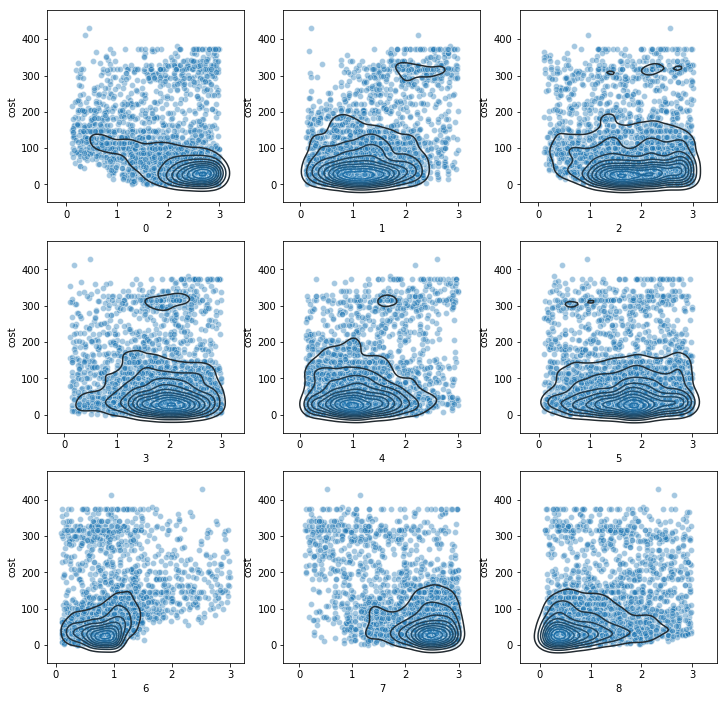

In [30]:
f,ax = plt.subplots(3,3,figsize = (12,12))
ax = ax.flatten()
for n in range(9):
    sns.kdeplot(df[n],df['cost'],ax = ax[n])
    sns.scatterplot(df[n],df['cost'],alpha = 0.4,ax = ax[n])

In [14]:
df = pd.DataFrame(np.stack(beta_))
df['cost'] = np.array(cost_)


,0,1,2,3,4,5,6,7,8,cost
0,0.823930,2.381083,1.038323,2.875637,2.375712,1.515974,1.493506,0.652964,1.939075,342.0000
1,2.284831,0.935385,1.377131,1.513695,2.243364,0.652130,0.461310,1.638905,2.453679,302.8900
2,1.538677,0.164640,2.810946,1.891562,0.334684,1.300336,0.198459,2.936650,0.262122,32.6025
3,1.908966,0.806269,2.052463,0.858984,1.697153,0.370800,0.369752,0.871965,0.879655,106.0000
4,2.190185,2.769527,0.622912,0.464326,2.828332,1.671758,0.599985,2.031123,0.536165,321.0000
5,2.266694,2.698507,1.943192,0.201585,2.908396,0.681297,0.773808,0.738206,2.351499,305.0000
6,2.341853,1.481093,1.846861,0.626249,1.376681,1.643781,2.074909,0.117163,2.077765,248.2850
7,2.768482,0.938564,2.028777,2.331981,2.561464,1.818618,2.120412,0.176568,0.972435,341.0000
8,0.865093,2.543461,2.981997,2.746036,1.827646,1.978885,0.678303,0.214907,2.429367,374.0000
9,1.132091,1.208565,2.786805,0.983728,0.439180,1.758592,2.501216,2.877916,1.003730,279.0025


In [ ]:
beta_true = np.array([1.19, 0.68, 1.4, 1.5, 0.73, 2.96,
 0.38, 1.60, 2.18])
rates, spikes = run_3_pop_w_ext_input(beta_true)

In [ ]:

# net.add()
net.store()

In [ ]:
net.restore()

In [ ]:
bins = np.arange(0,duration,1*ms)
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[i], bins = bins, color = cmap[i])
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.5);
    y_bias += params[ct]['N']
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))

In [ ]:

ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = 7 * nS
constructor.add_spikes(indices = array([0]), spikes = array([5])* ms)
pre, pre_params = constructor.generate_afferent_group()


ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['tau_e'] = 1 * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()


states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
    
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)  

net.store()

In [ ]:
net.run(duration, report = 'text',profile = True)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
plt.xlim((5,20))

In [ ]:
x = [7.1351391, 14.7825336, 2.29645621, 2.4902152]
ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
pre, pre_params = constructor.generate_afferent_group()
ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
constructor.params['intrinsics']['tau_e'] = x[3] * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()

states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)
net.run(duration)
fit_v = states.v_[0].copy()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
# plt.xlim((5,20))

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    pre, pre_params = constructor.generate_afferent_group()
    ct = 'i_gal'
    ngs = {}
    params = {}
    i_ex = {}
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
    constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
    constructor.params['intrinsics']['tau_e'] = x[3] * ms
    constructor.params['intrinsics']['E_l'] = -70 * mV
    post, post_params, i_ex = constructor.generate_neuron_group()

    states= StateMonitor(post, ['v','g_e','g_i'], record=True)
    spikes= SpikeMonitor(pre, record=True)
    syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

    initialize_I_ex(post, i_ex)

    net = Network(post,states,spikes,syn,pre)
    net.run(duration)
    fit_v = states.v_[0].copy()
    cost = np.sum((fit_v -train_v) **2)
    print(x, cost)
    return cost

In [ ]:
bounds = [(0.1,30),(13,20),(0.5,5),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
train_v = states.v_[0]

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    
  
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.params['outputs']['i_gal']['w_sigma'] = 0.0001 * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    cts = ['i_gal']
    ngs = {}
    params = {}
    i_ex = {}
    for ct in cts:
        constructor = neuron_group_constructor()
        constructor.select_cell_type(ct)
        constructor.params['N'] = 1
        constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
        constructor.params['intrinsics']['tau_e'] = x[2] * ms
        ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()

    states={}
    spikes = {}
    for cell_type in params:
        states[cell_type]= StateMonitor(ngs[cell_type], ['v','g_e','g_i'], record=True)
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)

    synapses=[]

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    print(pre,post)
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,states,spikes,synapses,af_ngs)
    net.run(duration)
    fit_v = states['i_gal'].v_[0].copy()
    return np.sum((fit_v -train_v) **2)


In [ ]:
bounds = [(0,50),(0.1,10),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
res

In [ ]:
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for n,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[n], bins = bins, color = cmap[n])
    ax[n].set_title(ct)
plt.tight_layout()


In [ ]:
reversed(ax.get_ylim())

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.1);
    y_bias += params[ct]['N']
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))

In [ ]:
f,ax = plt.subplots(len(spikes),1,figsize = (8,20), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax[i].plot(spike_mon.t/ms, spike_mon.i,'.', color = cmap[i],alpha = 0.1);
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
state_mon.v_.shape

In [ ]:
def make_spikes_pretty(spikemon,statemon,spike_height = 0.040):
    inds = spikemon.i
    time_inds = spikemon.t/sim_dt
    time_inds = time_inds.astype(int)
    for i,t in zip(inds,time_inds):
        statemon.v_[i,t] = spike_height

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,16))
for i,(ct,state_mon) in enumerate(states.items()):
    make_spikes_pretty(spikes[ct],state_mon)
    ax[i].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,8))
for i,(ct,state_mon) in enumerate(states.items()):
    ax[i].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
# afferent inputs
AB_psth,time_bins = gaussian_psth(mu = 10 * ms, sigma = 1 * ms)
AD_psth,time_bins = gaussian_psth(mu = 20 * ms, sigma = 2 * ms)
C_psth,time_bins = gaussian_psth(mu = 120 * ms, sigma = 20 * ms)

C_spikes, C_ind = generate_population_spikes(C_psth,np.ones(50)*2)
AB_spikes, AB_ind = generate_population_spikes(AB_psth,np.ones(10)*5)
AD_spikes, AD_ind = generate_population_spikes(AD_psth,np.ones(10)*5)
f, ax = plt.subplots(2,1,figsize = (8,8), sharex = True)
ax[0].plot(AB_spikes, AB_ind,'.k')
ax[0].plot(AD_spikes, AD_ind+10,'.b')
ax[0].plot(C_spikes, C_ind+20,'.r')
ax[1].plot(time_bins, AB_psth,'k')
ax[1].plot(time_bins, AD_psth,'b')
ax[1].plot(time_bins, C_psth,'r')

In [ ]:
E_l = -70 * mV
E_e = 0 * mV
E_i = -70 * mV
C_m = 200 * pF
V_th = -40 * mV
V_r = -50 * mV
tau_e = 5 * ms
tau_i = 5 * ms
tau_r = 1 * ms
g_l = 0.5 * nS
I_ex = 20 * pA

In [ ]:
# neuron_eqs = Equations('''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# g_l : siemens (constant)
# E_l : volt (constant)
# E_e : volt (constant)
# E_i : volt (constant)
# I_ex : amp
# C_m : farad (constant)
# tau_i : second (constant)
# tau_e : second (constant)
# ''')

neuron_eqs = Equations('''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
I_ex : amp (constant)
g_l : siemens (constant)
''')

# neuron_eqs = '''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# '''



synapses_eqs = Equations('''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
''')
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''

# maybe could switch to system where each synapse has a reversal potential
# rather than being excitatory vs inhibitory
# using (summed) 

In [ ]:
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler')
params = gen_default_params()
NG = NeuronGroup(2, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
for key, value in params.items():
    NG.namespace[key] = value

NG.g_i = '0 * nS'
NG.g_e = '0 * nS'
NG.v = '-70 * mV '
NG.namespace['I_ex'] = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = '(I_ex_mu + I_ex_sigma * randn())'
state_mon = StateMonitor(NG, ['v','I_ex','g_l'], record=True)

In [ ]:
I_ex = 

In [ ]:
NG.g_l = g_l
NG.E_l = E_l
NG.E_e = E_e
NG.E_i = E_i
NG.I_ex = I_ex
NG.C_m = C_m
NG.tau_i = tau_i
NG.tau_e = tau_e

In [ ]:
sub_G = NG[0:]
sub_G.namespace['I_ex'] = -50 * pA

In [ ]:
run(600 * ms)

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.v[1,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[1,:]/ms);
# ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
def gen_default_params():
    params = {}
    params['E_l'] = -70*mV           # Leak reversal potential
    params['E_e'] = 0*mV             # Excitatory synaptic reversal potential
    params['E_i'] = -70*mV           # Inhibitory synaptic reversal potential
    params['C_m'] = 200*pF           # Membrane capacitance
    params['V_th'] = -40*mV          # Firing threshold
    params['V_r'] = -60*mV           # Reset potential
    
    params['tau_e'] = 5*ms           # Excitatory synaptic time constant
    params['tau_i'] = 5*ms           # Inhibitory synaptic time constant
    params['tau_r'] = 1*ms           # Refractory period
    
    params['g_l_mu'] = 0.5 * nS
    params['g_l_sigma'] = 0.1 * nS
    
    params['I_ex_mu'] = 25 * pA
    params['I_ex_sigma'] = 20 * pA
    
    return params

In [ ]:
def gen_NG(N = 1,
           E_l = -70 * mV,
           E_e = 0 * mV,
           E_i = -70 * mV,
           C_m = 200 * pF,
           V_th = -40 * mV,
           V_r = -50 * mV,
           tau_e = 5 * ms,
           tau_i = 5 * ms,
           tau_r = 1 * ms,
           g_l_mu = 0.5 * nS,
           g_l_sigma = 0.1 * nS,
           I_ex_mu = 25 * pA,
           I_ex_sigma = 10 * pA,
           initialize = True):
    
    # constant parameters shared by all neurons in this group
    params['E_l'] = E_l 
    params['E_e'] = E_e 
    params['E_i'] = E_i 
    params['C_m'] = C_m 
    params['V_th'] = V_th 
    params['V_r'] = V_r
    params['tau_e'] = tau_e
    params['tau_i'] = tau_i
    params['tau_r'] = tau_r
    
    # constant parameters that vary between neurons in this group
    params['g_l'] = (g_l_mu + g_l_sigma * randn())
    
    params['I_ex'] = (I_ex_mu + I_ex_sigma * randn())

    
    NG = NeuronGroup(N, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
    
    for key, value in params.items():
        NG.namespace[key] = value
    
    if initialize:
        NG.g_i = '0 * nS'
        NG.g_e = '0 * nS'
        NG.v = E_l
    return NG

In [ ]:
# params = gen_default_params()
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler',
#                  namespace = params)
# P = PoissonGroup(10,50 * Hz)
# conn = Synapses(P,NG, model=synapses_eqs,
#                    on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)


# NG = gen_NG(N = 2)
net = Network(NG)
state_mon = StateMonitor(NG, ['v'], record=True)



In [ ]:
run(duration)

In [ ]:
state_mon.get_states()

In [ ]:
net.run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
df = NG.get_states(units = False, format = 'pandas')
df

In [ ]:

N_NK1R = 10             # Number of NK1R
N_nNOS = 10
N_TRPV1 = 100

### Neuron parameters
E_l = -70*mV           # Leak reversal potential
g_l = 0.5*nS           # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -70*mV           # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -40*mV          # Firing threshold
V_r = -60*mV           # Reset potential

### Synapse parameters
w_e = 1*nS          # Excitatory synaptic conductance
w_i = 3 * nS        # inhibitory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
Omega_d = 10/second   # Synaptic depression rate
Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
# P = PoissonGroup(N_ext,10 * Hz)

indices = []
times = []
rate = 5 
start_time = 0.1
stop_time = 1.5
for i in range(N_TRPV1):
    this_times = generate_periodic_spike_times(rate, start_time, stop_time) * second
    times.append(this_times) 
    indices.append(np.ones(this_times.shape)*i)
    
TRPV1 = SpikeGeneratorGroup(N_TRPV1,times = np.concatenate(times) * second,
                        indices = np.concatenate(indices))


In [ ]:
### Neurons

neurons = NeuronGroup(N_NK1R + N_nNOS, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')

# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
NK1R_neurons = neurons[:N_NK1R]
nNOS_neurons = neurons[N_NK1R:]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
TRPV1_to_NK1R = Synapses(TRPV1,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_NK1R.connect(p=1)
TRPV1_to_NK1R.x_S = 1

TRPV1_to_nNOS = Synapses(TRPV1,nNOS_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_nNOS.connect(p=1)
TRPV1_to_nNOS.x_S = 1

nNOS_to_NK1R = Synapses(nNOS_neurons,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S')
nNOS_to_NK1R.connect(p=1)
nNOS_to_NK1R.x_S = 1

# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources


# independent variable - changing the ratio of Omega_f to Omega_d
# exc_syn.Omega_f = np.logspace(-1,2,100) * Hz
# exc_syn.Omega_d = np.logspace(2,-1,100) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
NK1R_mon = SpikeMonitor(NK1R_neurons)
nNOS_mon = SpikeMonitor(nNOS_neurons)
spike_mon = SpikeMonitor(neurons)

ext_mon = SpikeMonitor(TRPV1)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(NK1R_neurons, ['v', 'g_e','g_i'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
# synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
#                            record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
NK1R_mon.t

In [ ]:
f,ax = plt.subplots(figsize = (10,10))
ax.plot(spike_mon.t/ms, spike_mon.i,'.')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**10,aspect = 'auto',vmin = 0, vmax = 0.5)

Now let's make the external inputs Poisson trains, from a population of 1000 neurons all firing at 10 Hz

In [ ]:

### General parameters
duration = 3*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_e = 100             # Number of excitatory neurons
N_ext = 1000

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 100*nS         # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
# Omega_d = 10/second   # Synaptic depression rate
# Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
P = PoissonGroup(N_ext,20 * Hz)


### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
'''
neurons = NeuronGroup(N_e, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
exc_neurons = neurons[:N_e]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S')

exc_syn.connect(p=1)
# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources
exc_syn.x_S = 1

# independent variable - changing the ratio of Omega_f to Omega_d
omega_fs = np.logspace(-1,2,100)
omega_ds = np.logspace(2,-1,100)

# exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
# exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)

ext_mon = SpikeMonitor(P)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                           record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**9,aspect = 'auto',vmin = 0, vmax = 2)



Okay, now let's change the distribution of firing rates among the external inputs while keeping the total number of input spikes roughly the same

In [ ]:
df_agg = []
sigma_frs = [0.01,0.1,0.2,0.3,0.4,0.5,1,2]
for sigma_fr in sigma_frs:

    mu_fr = 70

    ### General parameters
    duration = 3*second  # Total simulation time
    sim_dt = 0.1*ms        # Integrator/sampling step
    N_e = 100             # Number of excitatory neurons
    N_ext = 1000

    ### Neuron parameters
    E_l = -60*mV           # Leak reversal potential
    g_l = 100*nS         # Leak conductance
    E_e = 0*mV             # Excitatory synaptic reversal potential
    C_m = 200*pF           # Membrane capacitance
    tau_e = 5*ms           # Excitatory synaptic time constant
    tau_r = 5*ms           # Refractory period
    I_ex = 0*pA            # External current
    V_th = -50*mV          # Firing threshold
    V_r = E_l              # Reset potential

    ### Synapse parameters
    w_e = 0.05*nS          # Excitatory synaptic conductance
    U_0 = 0.1              # Synaptic release probability at rest
    # Omega_d = 10/second   # Synaptic depression rate
    # Omega_f = 0.1/second  # Synaptic facilitation rate

    ################################################################################
    # Model definition
    ################################################################################
    # Set the integration time (in this case not strictly necessary, since we are
    # using the default value)
    defaultclock.dt = sim_dt


    ### Neurons
    neuron_eqs = '''
    dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
             I_ex)/C_m    : volt (unless refractory)
    dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
    '''
    neurons = NeuronGroup(N_e, model=neuron_eqs,
                          threshold='v>V_th', reset='v=V_r',
                          refractory='tau_r', method='euler')
    # Random initial membrane potential values and conductances
    # neurons.v = 'E_l + rand()*(V_th-E_l)'
    # neurons.g_e = 'rand()*w_e'
    neurons.v = 'E_l'
    neurons.g_e = '0*w_e'
    exc_neurons = neurons[:N_e]

    ### Synapses
    synapses_eqs = '''
    Omega_f : 1/second
    Omega_d : 1/second
    # Usage of releasable neurotransmitter per single action potential:
    du_S/dt = -Omega_f * u_S     : 1 (event-driven)
    # Fraction of synaptic neurotransmitter resources available:
    dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
    '''
    synapses_action = '''
    u_S += U_0 * (1 - u_S)
    r_S = u_S * x_S
    x_S -= r_S
    '''

    frs = np.random.lognormal(np.log(10),sigma_fr,N_ext)
    frs = frs * mu_fr / frs.mean()
    ### External inputs
    P = PoissonGroup(N_ext,frs * Hz)

    exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                       on_pre=synapses_action+'g_e_post += w_e*r_S')

    exc_syn.connect(p=1)
    # Start from "resting" condition: all synapses have fully-replenished
    # neurotransmitter resources
    exc_syn.x_S = 1

    # independent variable - changing the ratio of Omega_f to Omega_d
    omega_fs = np.logspace(-2,2,100)
    omega_ds = np.logspace(2,-2,100)

    # exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
    # exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

    exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
    exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


    # ##############################################################################
    # # Monitors
    # ##############################################################################
    # Note that we could use a single monitor for all neurons instead, but in this
    # way plotting is a bit easier in the end
    exc_mon = SpikeMonitor(exc_neurons)

    ext_mon = SpikeMonitor(P)
    ### We record some additional data from a single excitatory neuron
    ni = 0
    # Record conductances and membrane potential of neuron ni
    state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
    # We make sure to monitor synaptic variables after synapse are updated in order
    # to use simple recurrence relations to reconstruct them. Record all synapses
    # originating from neuron ni
    synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                               record=exc_syn[:,ni], when='after_synapses')

    run(duration, report='text')
    g_e_ss = np.mean(np.array(state_mon.g_e[:,2000:30000]),axis = 1)
    df = pd.DataFrame({'omega_f':omega_fs,'omega_d':omega_ds,'g_e_ss':g_e_ss})
    df['sigma_fr'] = sigma_fr
    df['L1'] = frs.sum()
    df['L2'] = np.sum(frs ** 2) ** 0.5
    df['i'] = np.arange(N_e)
    df_agg.append(df)

In [ ]:
df = pd.concat(df_agg)


In [ ]:
groups = df.groupby('i')

I need to remember how to use pandas ugh

In [ ]:
norm = groups['g_e_ss'].apply(lambda x: x['g_e_ss']/x['g_e_ss'].max())

In [ ]:
df['g_e_ss_norm'] = norm.reset_index(drop = True)

In [ ]:
df[ind]

In [ ]:
ind = df['i'] == 0
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())
ind = df['i'] == 99
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
g_e_ss_norm = []
for i in range(100):
    ind = df['i'] == i
    g_e_ss_norm.append(df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
plt.imshow(np.stack(g_e_ss_norm),aspect = 'auto')

In [ ]:
f,ax = plt.subplots(4,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.v[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[99]/ms);
ax[2].plot(synapse_mon.t/ms, synapse_mon.x_S[0,:]/ms,'-');
ax[3].plot(synapse_mon.t/ms, synapse_mon.u_S[0,:]/ms),'-';

In [ ]:
plt.plot(exc_mon.t[exc_mon.i ]/ms,
           exc_mon.i[exc_mon.i ], '|', color='C0')

The Beta distribution is a special case of the Dirichlet distribution,
and is related to the Gamma distribution.  It has the probability
distribution function

f(x; a,b) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1}
                                                 (1 - x)^{\beta - 1},

where the normalisation, B, is the beta function,

B(\alpha, \beta) = \int_0^1 t^{\alpha - 1}
                             (1 - t)^{\beta - 1} dt.

In [ ]:
x = np.random.beta(10,1000,1000)

In [ ]:
?np.random.lognormal

In [ ]:
f, ax = plt.subplots()
x = np.random.lognormal(2.3,0.1,100000)
x2 = np.random.lognormal(2.3,0.5,100000)
sns.distplot(x, ax = ax)
sns.distplot(x2, ax = ax)

plt.yscale('log')

In [ ]:
np.sum(x2)